In [1]:
# импортируем библиотеки для работы с данными
import pandas as pd
from sklearn import preprocessing 

In [2]:
# загрузим данные
df = pd.read_csv("data/segmented_customers.csv")
# посмотрим на данные
df.head()

,customer_id,gender,age,annual_income,spending_score
0,1,1,19.0,15.0,39.0
1,2,1,21.0,15.0,81.0
2,3,0,20.0,16.0,6.0
3,4,0,23.0,16.0,77.0
4,5,0,31.0,17.0,40.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   customer_id     200 non-null    int64  
 1   gender          200 non-null    int64  
 2   age             200 non-null    float64
 3   annual_income   200 non-null    float64
 4   spending_score  200 non-null    float64
dtypes: float64(3), int64(2)
memory usage: 7.9 KB


Чтобы мы могли визуально оценивать результаты кластеризации, будем проводить её по трём признакам, а именно: годовой заработок, коэффициент покупательской способности и возраст. Визуализируем распределение данных:

In [5]:
import plotly
import plotly.express as px

# передаём датафрейм и поля, которые нужно использовать для осей абсцисс, ординат и аппликат
fig = px.scatter_3d(
    data_frame=df, 
    x = 'age', 
    y = 'annual_income', 
    z = 'spending_score', 
    width=1000,
    height=700
)

#отображаем график
fig.show()

In [6]:
# Функция для визуализации

def get_3d_visualization(df, clust_res):
    fig = px.scatter_3d(
        data_frame=df, 
        x = 'age', 
        y = 'annual_income', 
        z = 'spending_score', 
        color = clust_res,
        width=1000,
        height=700
    )

    #возвращаем график
    return fig

Сохраним признаки, по которым будем проводить моделирование, в переменную X:

In [7]:
X = df[['age', 'annual_income', 'spending_score']]

Попробуйте провести DBSCAN-кластеризацию со значениями по умолчанию. Сколько кластеров у вас получилось?

In [8]:
# импортируем DBSCAN кластеризацию
from sklearn.cluster import DBSCAN

#запускаем кластеризацию на наших данных
clustering = DBSCAN().fit(X)

# Далее можно визуализировать результаты, как мы делали с алгоритмом k-means
get_3d_visualization(X, clustering.labels_)

In [9]:
clustering.labels_

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=int64)

Алгоритм посчитал всё выбросами.

Большая часть наших данных разрежённые, а чем больше разброс точек в датасете, тем большее значение радиуса вокруг точки (eps) нужно задавать. Так как данные разрежённые, попробуем увеличить значение eps до 11 и визуально оценим результат:

In [18]:
from sklearn.cluster import DBSCAN

#запускаем кластеризацию на наших данных
dbscan = DBSCAN(eps=10, min_samples=2)
clustering_dbscan_res = dbscan.fit_predict(X)
df['dbscan_res_eps_11'] = clustering_dbscan_res

get_3d_visualization(df, 'dbscan_res_eps_11')

Распределение данных неоднородно: в одной области они имеют высокую плотность, в другой области — разряжены. Такие данные не подходят для успешной кластеризации алгоритмом DBSCAN.

Проведём агломеративную кластеризацию, чтобы построить дендрограмму и по ней оценить количество кластеров, на которое можно разделить датасет. Напишем функцию, которая будет принимать количество кластеров и матрицу с признаками:

In [19]:
# импортируем алгомеративную кластеризацию из sklearn
from sklearn.cluster import AgglomerativeClustering

# напишем функцию, которая будет проводить алгомеративную кластеризацию
# на вход она будет принимать X — матрицу с признаками для кластеризации и n_clusters — количество кластеров,
# на выходе будет возвращать список с номерами кластеров
def get_aggl_clustering(X, n_clusters):
    # запустим агломеративную кластеризацию
    agglomerative_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    # обучим модель агломеративной кластеризации
    agglomerative_clustering.fit(X)
    # получим список c информацией, к какому кластеру относятся объекты
    aggl_prediction = agglomerative_clustering.labels_
    # вернём список с результатами
    return aggl_prediction

In [22]:
labels = get_aggl_clustering(X, 3)

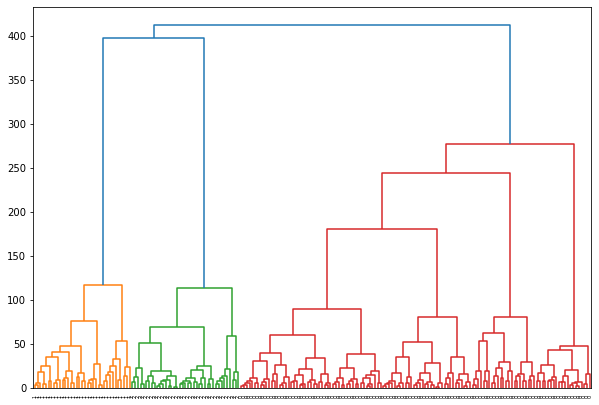

In [29]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 7))

linked = linkage(X, 'ward')

dendrogram( linked,
            orientation='top',
            labels=labels,
            distance_sort='descending',
            show_leaf_counts=True)

plt.show()

In [30]:
df['aggl_res_6'] = get_aggl_clustering(df[['age', 'annual_income', 'spending_score']], 6)
get_3d_visualization(df, 'aggl_res_6')

Для агломеративной кластеризации самостоятельно с помощью коэффициента силуэта подберите оптимальное количество кластеров. Сколько кластеров у вас получилось?

<AxesSubplot:xlabel='cluster', ylabel='silhouette'>

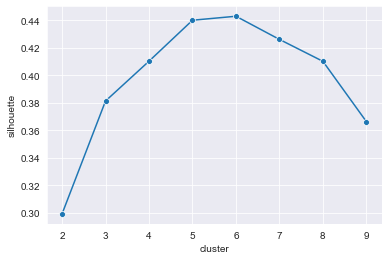

In [32]:
from sklearn.metrics import silhouette_score
import seaborn as sns

# напишем функцию для подсчёта коэффициента силуэта
def get_silhouette_agg_clust(X, cluster_num):
    # проведём агломеративную кластеризацию с заданным количеством кластеров
    res = get_aggl_clustering(X, cluster_num)
    # рассчитаем коэффициент силуэта
    silhouette = silhouette_score(X, res)
    return silhouette


# создадим пустой словарь, ключами будут коэффициент силуэта и количество кластеров
silhouette_res = {"silhouette": [], "cluster": []}


for cluster_num in range(2, 10):
    silhouette_res["silhouette"].append(get_silhouette_agg_clust(X, cluster_num))
    silhouette_res["cluster"].append(cluster_num)

# сохраним в датафрейм значение силуэта и количество кластеров
silhouette_df = pd.DataFrame(silhouette_res)

# установим стиль для визуализиции
sns.set_style("darkgrid")
# визуализируем зависимость значения инерции от количества кластеров
sns.lineplot(data=silhouette_df, x="cluster", y="silhouette", marker="o")